# Machine Learning Engineer Nanodegree
## Capstone Project
Patrick Poon  
May 1, 2018

## I. Definition
_(approx. 1-2 pages)_

### Project Overview

<!--
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_
-->

> Most people...the interaction that they're going to have with a police officer is because [...] they're stopped for speeding.  Or, forgetting to turn their blinker off.[1]
> 
>-- Cheryl Phillips, Journalism Professor at Stanford University

On a typical day in the United States, police officers make more than 50,000 traffic stops.[2]  In recent years, there have been numerous incidents that have made national headlines that involve an officer shooting and, in some cases, killing the driver or an occupant.  Many cite racial biases against Blacks and Hispanics for the disproportionate amount of such incidents for these communities.  Here are some relevant articles:

- Was the Sandra Bland traffic stop legal -- and fair? (https://www.cnn.com/2015/07/23/opinions/cevallos-sandra-bland-traffic-stop/index.html)
- Philando Castile shooting: Dashcam video shows rapid event (https://www.cnn.com/2017/06/20/us/philando-castile-shooting-dashcam/index.html)

This Capstone project will not attempt to prove or disprove this controversial topic, and will attempt to  avoid making any controversial or provocative statements on either side of the conversation.


### Problem Statement

<!--
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_
-->

Instead, this project aims to create a multi-class classifier that takes various discrete traffic stop situational values to predict the outcome of a traffic stop, specifically in the state of Connecticut (CT).  Given a driver's age, gender, race, violation, and the county where the traffic stop occurs, can we reliably predict whether the traffic stop will result in a verbal/written warning, a ticket, a summons to appear in court, or an arrest?

To accomplish this task, I will parse and process traffic stop data for the state of Connecticut, and feed it into a supervised learning algorithm that I will train and tune to predict these outcomes.


### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_


As far as I know, there is no external benchmark to assess the accuracy of a traffic stop outcome prediction.  From my analysis of the data, a naive predictor would be appropriate to set a benchmark.  The most common `stop_outcome` value in this dataset is 'Ticket' which comprises 70% of all stop outcomes as described in the following table:

| Outcome         | Count   |    %   |
|:----------------|--------:|-------:|
|Arrest           |   7,312 |  2.33% |
|Summons          |  12,205 |  3.90% |
|Ticket           | 218,973 | 69.89% |
|Verbal Warning	  |  47,753 | 15.24% |
|Written Warning  |  27,070 |  8.64% |
|                 | 313,313 |        |

As a base model without any intelligence, predicting every traffic stop outcome as 'Ticket' will generate an accuracy score of around 0.70 and serve as our benchmark model.

Initially, I had planned on using the F-beta score for my evaluation metric, but after some tests, I encountered the following error when attempting to do so:
```
ValueError: Sample-based precision, recall, fscore is not meaningful outside multilabel classification. See the accuracy_score instead.
```
Instead, I will use **accuracy classification score** as my evaluation metric.  According to the sklearn page for the `accuracy_score` function[5], in the context of multiclass classification, the function is equivalent to the `jaccard_similarity_score` which calculates the Jaccard index, also known as "Intersection over Union," as illustrated in the following formula:

<center>
![Intersection over Union formula](./images/IoU.svg)
</center>

TODO: Add reference to wiki source:  https://en.wikipedia.org/wiki/Jaccard_index ?

## II. Analysis
_(approx. 2-4 pages)_

### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any Mabnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

In [2]:
import humanize
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline

In [3]:
df = pd.read_csv('./data/CT-clean.csv', header=0)

D:\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The raw data is comprised of 318,669 records with 24 features over a period of 1 year and 5 months from 2013 to 2015.  Here are a few sample rows with the feature columns broken down into three sections due to width restrictions of this document (**Please note**: Different rows have been selected for each section to provide a sense of the complexity involved with different columns in this dataset):

In [4]:
df.iloc[:,:8].head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location
0,CT-2013-00001,CT,2013-10-01,00:01,westport,Fairfield County,9001.0,"00000 N I 95 (WESTPORT, T158) X 18 LL"
1,CT-2013-00002,CT,2013-10-01,00:02,mansfield,Tolland County,9013.0,rte 195 storrs
2,CT-2013-00003,CT,2013-10-01,00:07,franklin,New London County,9011.0,Rt 32/whippoorwill
3,CT-2013-00004,CT,2013-10-01,00:10,danbury,Fairfield County,9001.0,I-84
4,CT-2013-00005,CT,2013-10-01,00:10,east hartford,Hartford County,9003.0,"00000 W I 84 (EAST HARTFORD, T043)E.OF XT.56"


<br>

In [5]:
df.iloc[24500:24506,8:16].head()

,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation
24500,State Police,M,39,39.0,White,White,Speed Related,Speeding
24501,State Police,M,62,62.0,White,White,"Cell Phone,Other","Cell phone,Other"
24502,State Police,F,31,31.0,White,White,Registration,Registration/plates
24503,State Police,F,50,50.0,Hispanic,Hispanic,Other,Other
24504,State Police,M,28,28.0,White,White,Registration,Registration/plates


<br>

In [6]:
df.iloc[242:248,16:24].head()

,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration
242,False,NaN,NaN,False,Verbal Warning,False,1000002364,1-15 min
243,False,NaN,NaN,False,Ticket,False,1000001904,16-30 min
244,False,NaN,NaN,False,Summons,False,41354688,1-15 min
245,False,NaN,NaN,False,Written Warning,False,348145142,1-15 min
246,False,NaN,NaN,False,Ticket,False,1000001914,1-15 min


The main objective for this project is to create a multi-class classifier that reliably predicts the outcome of a traffic stop in the state of Connecticut.  In this section, I will break down and decompose the raw data into its basic elements.  In doing so, I will attempt to gain insights that may guide me at different points on this journey to develop an effective and accurate algorithm.


The dataset is primarily comprised of discrete categorical values with only three columns that contain numerical data, namely `driver_age`, `driver_age_raw`, and `county_fips`.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318669 entries, 0 to 318668
Data columns (total 24 columns):
id                       318669 non-null object
state                    318669 non-null object
stop_date                318669 non-null object
stop_time                318447 non-null object
location_raw             318628 non-null object
county_name              318627 non-null object
county_fips              318627 non-null float64
fine_grained_location    317006 non-null object
police_department        318669 non-null object
driver_gender            318669 non-null object
driver_age_raw           318669 non-null int64
driver_age               318395 non-null float64
driver_race_raw          318669 non-null object
driver_race              318669 non-null object
violation_raw            318669 non-null object
violation                318669 non-null object
search_conducted         318669 non-null bool
search_type_raw          4846 non-null object
search_type              484

However, **`county_fips`** is unlikely to yield any predictive benefit as the values are simple label identifiers for values in the **`county_name`** column.  The **`county_fips`** column can be dropped, and the **`county_name`** column will be one-hot encoded.

Also, the driver's age is more characteristic of a discrete categorical value rather than a continuous value.  Whether a driver is 24.5-year-old will not likely increase or decrease their chances of getting arrested during a traffic stop, compared to a driver who is 26.8-year-old.  However, that 24.5-year-old driver may have a higher chance than a 36- or 46-year-old.

The **`driver_age`** column can be dropped as it duplicates information in the **`driver_age_raw`** column.  Plus, **`driver_age`** has some missing values, as the following table shows:

In [107]:
df.isnull().sum().to_frame('null values count')

,null values count
id,0
state,0
stop_date,0
stop_time,222
location_raw,41
county_name,42
county_fips,42
fine_grained_location,1663
police_department,0
driver_gender,0


One glaring observation with this table is that the **`search_type_raw`** and **`search_type`** columns should be dropped.  These fields provide supplementary information when a search is conducted, with both columns containing one of the following values:  "Consent", "Other", "Inventory", or `nan`.  The **`search_conducted`** boolean column by itself should provide an adequate signal about a probable outcome when a car search is involved.

The next two columns that have the highest number of null values are **`stop_outcome`** and **`is_arrested`**.  The **`is_arrested`** column should be dropped, because it duplicates information that we can get from the **`stop_outcome`** field, where "Arrest" is one of its values.  Also, the rows that contain null values for **`stop_outcome`** should be dropped as the main objective of this project is to predict the outcome of a traffic stop.  It would not make sense to replace the null value in this column with a median or average value.

There are a few other columns that make sense to drop:  
- **`id`** column values, like "CT-2013-00001", provide no predictive value.
- **`state`** and **`police_department`** columns only have one value each, "CT" and "State Police" respectively. 
- **`location_raw`** contains the specific city in which a traffic stop occurred, but this data may be too granular, and better insight would be gained by using the **`county_name`** instead.
- **`fine_grained_location`** has values that are too specific, inconsistent, and non-standardized.  They appear to be notes that the officer took about the spot where the traffic stop was conducted.
- **`driver_race_raw`** column duplicates data in the **`driver_race` column.
- **`officer_id`** has 2,105 unique values and might be too granular, making overfitting likely.



#### Traffic Stop Outcome Breakdown

Looking at the breakdown of the `stop_outcome` feature of the raw data, it is clear that the data set is **highly unbalanced**.  A vast majority of traffic stops result in the officer issuing a "`Ticket`" in 69.89% of the cases.  "`Arrest`"s comprise only 2.33% of traffic stops.  Fortunate drivers are issued warnings, verbal and/or written, 23.9% of the time, while some unfortunate drivers receive a "`Summon`"s to appear in court in 3.9% of traffic stops.

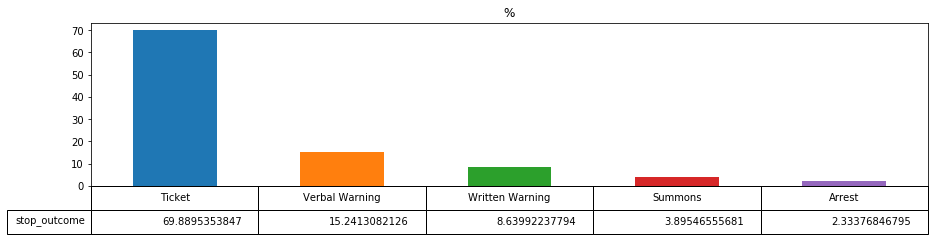

In [86]:
outcome_breakdown = df['stop_outcome'].value_counts(normalize=True).mul(100).plot.bar(figsize=(15, 3), table=True, title='%')
outcome_breakdown.axes.get_xaxis().set_visible(False)
outcome_breakdown.tables[0].scale(1, 2)

#### Proportion of Searches Conducted Relative to All Stops

One interesting data point that CT officers collect is whether a search was conducted during the traffic stop, as captured in the `search_conducted` column.  Intuitively, these traffic stops would correlate with a higher number of outcomes resulting in an `Arrest`.

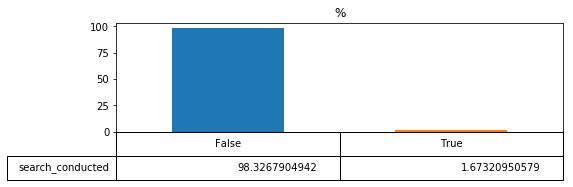

In [87]:
searches = df['search_conducted'].value_counts(normalize=True).mul(100).plot.bar(figsize=(8, 2), table=True, title="%")
searches.axes.get_xaxis().set_visible(False)
searches.tables[0].scale(1, 2)

#### Outcomes When Vehicle Searched

Indeed, the number of Arrests rises to 27.69% of traffic stops when a search is conducted.

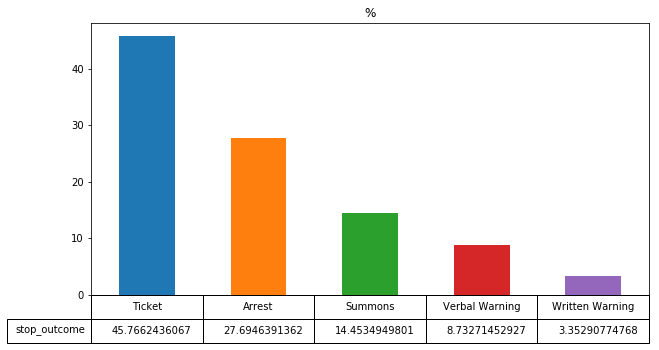

In [89]:
outcome_when_searched = df[df['search_conducted'] == True]['stop_outcome'].value_counts(normalize=True).mul(100).plot.bar(figsize=(10, 5), table=True, title='%')
outcome_when_searched.axes.get_xaxis().set_visible(False)
outcome_when_searched.tables[0].scale(1, 2)

Still, searches only comprise 1.7% of all traffic stops, so the fact remains that the data set is highly unbalanced.

#### Outcome by `stop_duration`

Another interesting data point is the duration of the traffic stop in the `stop_duration` column, which may provide another predictive signal about the likely outcome.  Logically speaking, the longer the duration of a traffic stop, the more likely the outcome will be an `Arrest`, as the officer may need to ask more questions, search the vehicle, conduct a sobriety test, and perform other duties that take time and extend the duration of the traffic stop.  

In [31]:
duration_outcomes = df.groupby(['stop_duration', 'stop_outcome'])
duration_outcomes.agg({'id': 'count'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename(columns={'id': '%'})

%
stop_duration stop_outcome              
1-15 min      Arrest            1.013722
              Summons           1.589788
              Ticket           72.027864
              Verbal Warning   16.208687
              Written Warning   9.159939
16-30 min     Arrest           10.637817
              Summons          28.381064
              Ticket           51.237691
              Verbal Warning    6.089078
              Written Warning   3.654350
30+ min       Arrest           35.641513
              Summons          23.916422
              Ticket           35.814194
              Verbal Warning    2.555690
              Written Warning   2.072181

As suspected, the chances of a traffic stop resulting in an `Arrest` is much higher when the stop lasts longer than 30 minutes at 35.64% than 1.01% when the stop lasts 15 minutes or less.

#### Race Breakdown

Another potential signal for the outcome of a traffic stop is race.



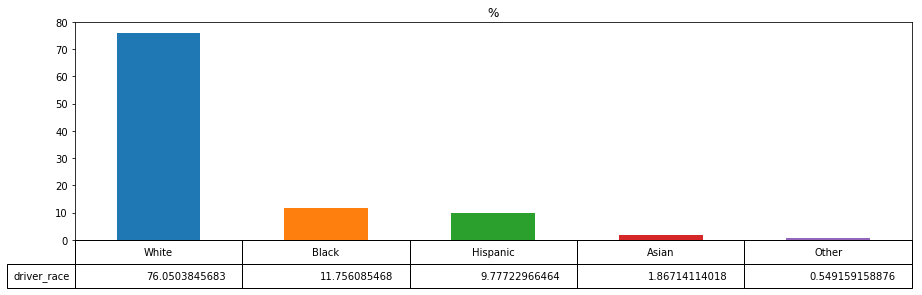

In [93]:
stops_by_race = df['driver_race'].value_counts(normalize=True).mul(100).plot.bar(figsize=(15, 4), table=True, title='%')
stops_by_race.axes.get_xaxis().set_visible(False)
stops_by_race.tables[0].scale(1, 2)

The dataset shows that the majority (76%) of traffic stops involved "`White`"s, with "`Black`"s at 11.75%, "`Hispanic`"s at 9.78%, "`Asian`"s at 1.87%, and a catch-all value of "`Other`" at 0.55%.  This approximately matches the 2010 census figures for Connecticut [**TODO**: reference?], where the racial composition is 77.57% "`White`", 10.14% "`Black`", 13.4% "`Hispanic`", 3.79% "`Asian`", and roughly 5.55% "`Other`".  For some reason, Hispanics are separated out by Ethnicity, so the numbers I provided have some overlap and sum to more than 100%.

![CT 2010 Census Data](./images/CT-2010-census-data.PNG)

One interesting note about the `Other` value is that in the `driver_race_raw` column of the dataset, this value was denoted as "`Native American`" and was subsequently replaced with "`Other`" in the `driver_race` column.

#### Arrests by Race by County

Looking for further insights, I thought it might be interesting to analyze racial breakdown of traffic stops by county.

In [37]:
df.loc[df['stop_outcome'] == 'Arrest'].groupby(['county_name', 'driver_race']).agg({'id': 'count'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename(columns={'id': '%'})

%
county_name       driver_race           
Fairfield County  Asian         1.007049
                  Black        16.918429
                  Hispanic     28.700906
                  Other         0.604230
                  White        52.769386
Hartford County   Asian         1.319797
                  Black        23.553299
                  Hispanic     19.289340
                  Other         0.507614
                  White        55.329949
Litchfield County Asian         1.140065
                  Black         3.094463
                  Hispanic     10.097720
                  Other         0.325733
                  White        85.342020
Middlesex County  Asian         1.206897
                  Black        12.586207
                  Hispanic     13.103448
                  White        73.103448
New Haven County  Asian         0.922819
                  Black        17.533557
                  Hispanic     22.315436
                  Other         0.251678
                  White        58.976510
New London County Asian         1.277235
                  Black         8.715252
                  Hispanic      9.541698
                  Other         0.450789
                  White        80.015026
Tolland County    Asian         1.121076
                  Black         7.735426
                  Hispanic      9.865471
                  Other         0.112108
                  White        81.165919
Windham County    Asian         0.698324
                  Black         4.748603
                  Hispanic     17.318436
                  Other         0.418994
                  White        76.815642

While the racial breakdown of traffic stops for the state overall are, for the most part, consistent with 2010 census data, these figures suggest that there are certain counties where Blacks and Hispanics are pulled over disproportionately higher than their composition in the 2010 census, namely Fairfield, Hartford, and New Haven counties.

#### Traffic Stops by County

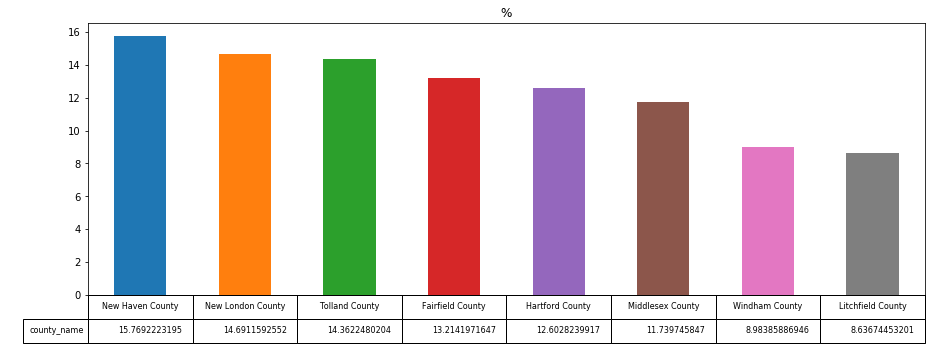

In [95]:
outcomes_by_county = df['county_name'].value_counts(normalize=True).mul(100).plot.bar(figsize=(15, 5), title='%', table=True)
outcomes_by_county.axes.get_xaxis().set_visible(False)
outcomes_by_county.tables[0].scale(1, 2)

#### Gender Breakdown

Twice as many men got pulled over compared to women, as men comprised almost exactly two-thirds (66.5%) of this dataset.

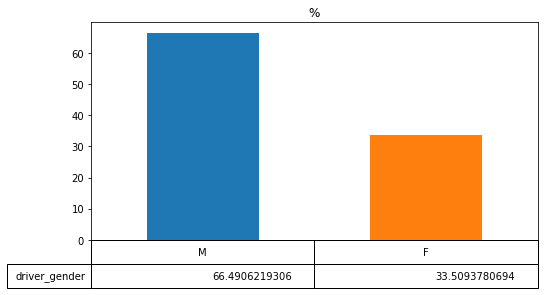

In [98]:
gender_vbar = df['driver_gender'].value_counts(normalize=True).mul(100).plot.bar(figsize=(8, 4), table=True, title='%')
xaxis = gender_vbar.axes.get_xaxis()
xaxis.set_visible(False)
table = gender_vbar.tables[0]
table.scale(1, 2)

#### Age Breakdown

The majority of those pulled over are in their 20's at 30.66%, with those in their 30's and 40's following suit, at 20.9% and 18.9% respectively.

In [53]:
df['driver_age_raw'].describe()

count    318669.000000
mean         38.088041
std          14.463289
min           0.000000
25%          26.000000
50%          35.000000
75%          49.000000
max          99.000000
Name: driver_age_raw, dtype: float64

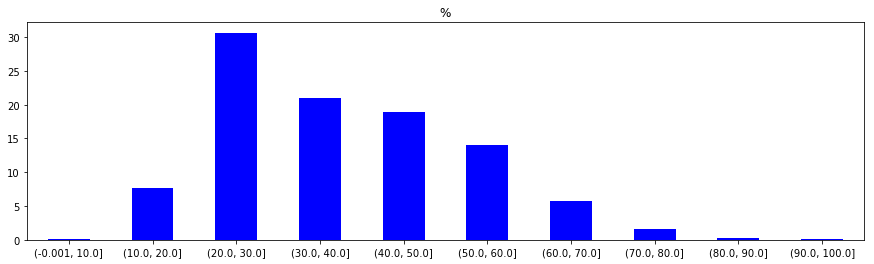

In [101]:
age_bins = pd.cut(df['driver_age_raw'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], include_lowest=True)
ax = age_bins.value_counts(sort=False, normalize=True).mul(100).plot.bar(rot=0, color="b", figsize=(15,4), title='%')


274 records specify ages that are less than 15 years-old, which I assume are typos and will remove in the pre-processing stage.

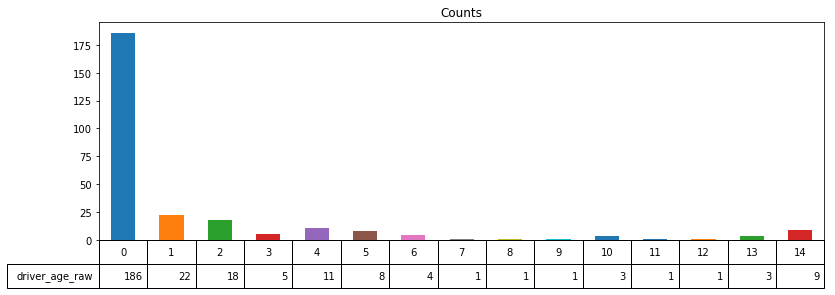

In [103]:
weird_ages = df[df["driver_age_raw"] < 15]['driver_age_raw'].value_counts(sort=False).plot.bar(figsize=(13, 4), table=True, title='Counts')
xaxis = weird_ages.axes.get_xaxis()
xaxis.set_visible(False)
table = weird_ages.tables[0]
table.scale(1, 2)

### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_

## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?